# **Cars location recognition**

Task:
Train neural network that can find location of car on small image - rotation, width, length and shift from center.

# Loading dataset

In [9]:
import os
import re
import gc
import json
import math
import time
import copy
import random
import functools as ft
from PIL import Image
from PIL import ImageDraw
from PIL import ImageEnhance
import random
import pathlib
import zipfile
import psutil
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [10]:
drive.mount('/content/drive', force_remount=True)
CARS_DS_ZIPFILE_PATH = '/content/drive/My Drive/fragm_ds.zip'

zfile = zipfile.ZipFile(CARS_DS_ZIPFILE_PATH, 'r')

DS_DIR = pathlib.Path('/content/ds')
if not DS_DIR.exists():
    os.mkdir(DS_DIR)
    zfile.extractall(DS_DIR)

IMG_FOLDER = DS_DIR / 'fragm_ds' / 'images'
LABELS_FOLDER = DS_DIR / 'fragm_ds' / 'labels'

orig_dataset = []
for label_name in sorted(os.listdir(LABELS_FOLDER)):
    label_path = LABELS_FOLDER / label_name
    label = None
    with open(label_path) as file:
        label = json.load(file)
    filename, mark = label['filename'], label['mark']
    image_path = IMG_FOLDER / filename
    orig_dataset.append((image_path, mark))

def explore_dataset(orig_dataset):
    print('Number of all images in dataset: {}'.format(len(orig_dataset)))
    print('\nDataset content:')
    print(*orig_dataset[:3], sep='\n')
    print('...')
explore_dataset(orig_dataset)

Mounted at /content/drive
Number of all images in dataset: 2951

Dataset content:
(PosixPath('/content/ds/fragm_ds/images/000000.png'), {'center_x': 25.0, 'center_y': 25.0, 'width': 9, 'length': 20, 'rot_deg': -8})
(PosixPath('/content/ds/fragm_ds/images/000001.png'), {'center_x': 25.0, 'center_y': 25.0, 'width': 9, 'length': 20, 'rot_deg': -9})
(PosixPath('/content/ds/fragm_ds/images/000002.png'), {'center_x': 25.0, 'center_y': 25.0, 'width': 10, 'length': 23, 'rot_deg': -8})
...


Exception ignored in: <bound method ZipFile.__del__ of <zipfile.ZipFile [closed]>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/zipfile.py", line 1686, in __del__
    self.close()
  File "/usr/lib/python3.6/zipfile.py", line 1708, in close
    self._fpclose(fp)
  File "/usr/lib/python3.6/zipfile.py", line 1816, in _fpclose
    fp.close()
OSError: [Errno 107] Transport endpoint is not connected


# Preprocessing

In [11]:
class Mark():
    cx, cy, width, length, rot = 0., 0., 0., 0., 0.
    def __init__(self, cx, cy, width, length, rot):
        self.cx, self.cy = cx, cy
        self.width, self.length, self.rot = width, length, rot
    def as_list(self):
        return [self.cx, self.cy, self.width, self.length, self.rot]
    def __str__(self):
        return 'cx={:.1f}, cy={:.1f}, w={:.1f}, l={:.1f}, r={:.1f}'.format(
            self.cx, self.cy, self.width, self.length, self.rot)

def deserialize_mark(mark_dict):
    return Mark(mark_dict['center_x'], mark_dict['center_y'],
                mark_dict['width'], mark_dict['length'],
                mark_dict['rot_deg'])

def get_img(path):
    img = Image.open(path)
    img.load()
    return img

def plot_img(img, title=''):
    plt.xticks([])
    plt.yticks([])
    if title:
        plt.title(title)
    plt.imshow(img, cmap=plt.cm.binary)

def create_rotation_xf(rotation):
    """Make transform matrix for ratation around zero-point."""
    a = math.radians(rotation)
    return np.array([[math.cos(a), -math.sin(a), 0],
                     [math.sin(a),  math.cos(a), 0],
                     [0, 0, 1]])

def create_scale_xf(s):
    return np.array([[s, 0, 0],
                     [0, s, 0],
                     [0, 0, s]])

def create_translation_xf(translation):
    tx, ty = translation
    return np.array([[1, 0, tx],
                     [0, 1, ty],
                     [0, 0,  1]])

def create_rotation_around_center_xf(rotation, center_of_rotation=None):
    if center_of_rotation:
        cx, cy = center_of_rotation
        tr_fwd = create_translation_xf((-cx, -cy))
        rot = create_rotation_xf(rotation)
        tr_bwd = create_translation_xf((cx, cy))
        return np.matmul(np.matmul(tr_bwd, rot), tr_fwd)
    else:
        return create_rotation_xf(rotation)

def combine_xfs(xf_list):
    res = np.identity(3, dtype=np.float32)
    for xf in xf_list:
        res = np.matmul(res, xf)
    return res

def apply_xf(points, xf):
    # points - list of tuples, xf - np.array(3x3), retval - list of tuples
    res = []
    for pt in points:
        new_pt = np.matmul(xf, np.array([pt[0], pt[1], 1]))
        res.append((new_pt[0], new_pt[1]))
    return res

def plot_images(images, titles=[], col_num=10):
    num = len(images)
    FW = 15 / col_num
    row_num = (num - 1) // col_num + 1
    plt.figure(figsize=(FW * col_num, 1.05 * FW * row_num))
    for k, img  in enumerate(images):
        plt.subplot(row_num, col_num, k+1)
        t = titles[k] if k < len(titles) else ''
        plot_img(img, t)

def is_rect_inside_img(img, rect):
    w, h = img.size
    return rect[0] >= 0 and rect[1] >= 0 and rect[2] < w and rect[3] < h

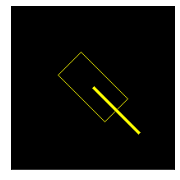

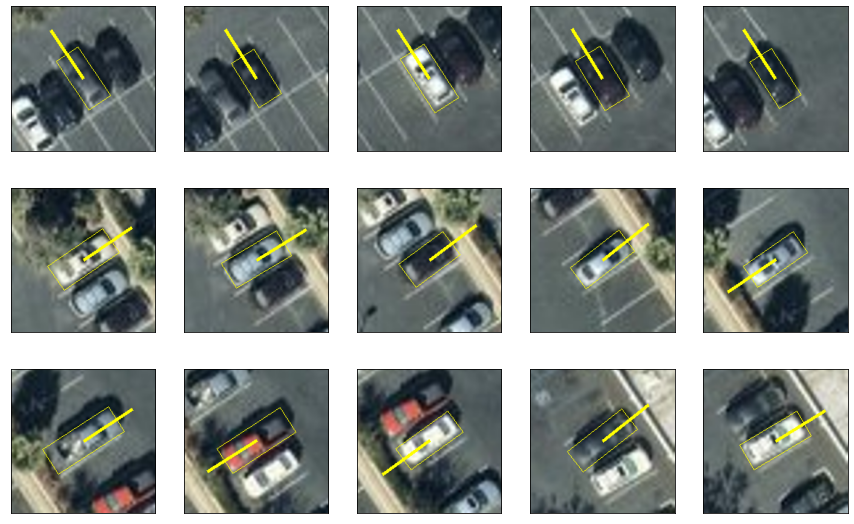

In [28]:
def draw_mark_layer(img, scale, mark, color):
    DIR_LEN = 20
    m = mark
    rot_xf = create_rotation_around_center_xf(m.rot)
    trans_xf = create_translation_xf((m.cx, m.cy))
    scale_xf = create_scale_xf(scale)
    xf = combine_xfs([trans_xf, rot_xf, scale_xf])
    draw = ImageDraw.Draw(img)
    pline = [(m.length / 2, m.width / 2), (m.length / 2, -m.width / 2),
              (-m.length / 2, -m.width / 2), (-m.length / 2, m.width / 2)]
    box_pts = apply_xf(pline, xf)
    draw.polygon(box_pts, outline=color)
    arrow_pts = apply_xf([(0, 0), (DIR_LEN, 0)], xf)
    draw.line(arrow_pts, fill=color, width=4)
    return img

def draw_marks(img, marks, color='yellow'):
    img = img.convert('RGBA')
    UPSC_C = 4
    UPSC_SZ = (img.width * UPSC_C, img.height * UPSC_C)
    img = img.resize(UPSC_SZ)
    mark_img = Image.new('RGBA', UPSC_SZ, color=(0, 0, 0, 0))
    for mark in marks:
        draw_mark_layer(mark_img, UPSC_C, mark, color=color)
    img.alpha_composite(mark_img)
    return img

def draw_mark(img, mark, color='yellow'):
    return draw_marks(img, [mark], color=color)

def draw_mark_check():
    img = Image.new('RGB', (50, 50), color='black')
    mark = Mark(25, 25, 10, 20, 45)
    img = draw_marks(img, [mark])
    plt.figure(figsize=(3,3))
    plot_img(img)
    plt.show()

def load_dataset(original_dataset):
    result = []
    for img_path, mark_dict in original_dataset:
        mark = deserialize_mark(mark_dict)
        img = get_img(img_path)
        result.append([img, mark])
    return result

def plot_fragments_with_marks(begin_index, end_index):
    small_ds = dataset[begin_index:end_index]
    for_draw = list(map(lambda tpl: draw_mark(*tpl), small_ds))
    plot_images(for_draw, col_num=5)

dataset = load_dataset(orig_dataset)
draw_mark_check()
plot_fragments_with_marks(5,20)

# Batch generation

In [13]:
FR_W = 50  # width of fragment
IN_SHAPE = (FR_W, FR_W, 3)
OUT_SHAPE = (6,)

Check of preprocessing functions:

Sample generated with rot=135, shift=(2, 2), scale=1.100



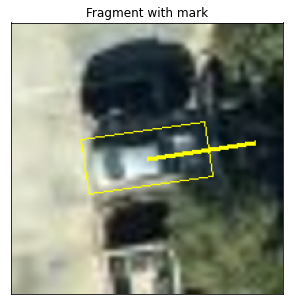

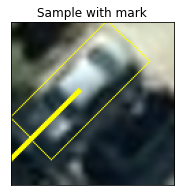

In [29]:
# Some designations:
# prefix 'fr', 'fragm', 'fragment' - corresponds with big image, cropped from
# initial dataset (and appropriate location)
# prefix 'smpl', 'sample' - corresponds with smaller image that cropped from
# fragment (and appropriate location)

SIMG_W = 30  # final image width

def crop_sample_from_fragment(fr_img, fr_mark, rotation, shift=(0,0), scale=1):
    fm = copy.deepcopy(fr_mark)
    simg = fr_img.copy()
    pill_angle = fm.rot - rotation
    if abs(scale - 1) > 0.001:
        simg = simg.resize((int(round(simg.width * scale)),
                            int(round(simg.height * scale))))
        fm.cx, fm.cy = fm.cx * scale, fm.cy * scale
        fm.width, fm.length = fm.width * scale, fm.length * scale
    simg = simg.rotate(pill_angle, resample=Image.BICUBIC,
                       center=(fm.cx, fm.cy), fillcolor='red')
    xmin = int(round(fm.cx)) - SIMG_W / 2 + shift[0]
    ymin = int(round(fm.cy)) - SIMG_W / 2 + shift[1]
    s_img = simg.crop([xmin, ymin, xmin + SIMG_W, ymin + SIMG_W])
    s_mark = copy.deepcopy(fm)
    s_mark.cx, s_mark.cy, s_mark.rot = fm.cx - xmin, fm.cy - ymin, rotation
    return s_img, s_mark

def sample_preprocessing_check():
    print('Check of preprocessing functions:\n')
    fr_img, fr_mark = dataset[2]
    plt.figure(figsize=(5,5))
    plot_img(draw_mark(fr_img, fr_mark), title='Fragment with mark')
    s_rot = 135
    s_shift = (2,2)
    s_scale = 1.1
    print('Sample generated with rot={}, shift={}, scale={:.3f}\n'.format(
        s_rot, s_shift, s_scale))
    s_img, s_mark = crop_sample_from_fragment(fr_img, fr_mark, rotation=s_rot,
                                              shift=s_shift, scale=s_scale)
    plt.figure(figsize=(3,3))
    plot_img(draw_mark(s_img, s_mark), title='Sample with mark')
    return plt
sample_preprocessing_check().show()

Check of border augmentation:



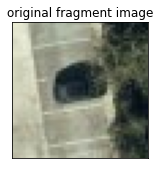

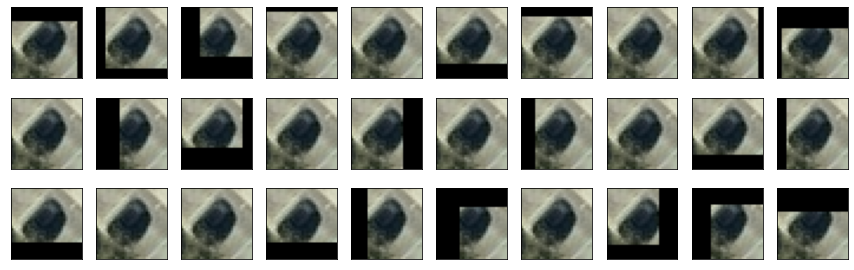

In [30]:
# Border augmentation function try to add borders in corresponding with natural
# probability - 10% (for each side independently). It means 18% for all borders.
ONE_SIDE_BORDER_PROB = 0.10

def augment_border(x, prob=ONE_SIDE_BORDER_PROB):
    tx, ty = 10, 10  # border thickness
    x = copy.deepcopy(x)
    h, w, _ = x.shape
    if random.random() < prob:
        i = random.randrange(-tx, tx)
        (begin, end) = (0, i+1) if i >= 0 else (w+i, w)
        border_arr = np.zeros((h,end-begin,3), dtype=np.int32)
        x[:, begin:end, :] = border_arr
    if random.random() < prob:
        j = random.randrange(-ty, ty)
        (begin, end) = (0, j+1) if j >= 0 else (h+j, h)
        border_arr = np.zeros((end-begin,w,3), dtype=np.int32)
        x[begin:end, :, :] = border_arr
    return x

def augment_border_check():
    print('Check of border augmentation:\n')
    f_img, f_mark = dataset[0]
    plt.figure(figsize=(2.5, 2.5))
    plot_img(f_img, 'original fragment image')
    plt.show()
    s_img, s_mark = crop_sample_from_fragment(f_img, f_mark,
                                              rotation=135, shift=(2,2))
    x = np.array(s_img, dtype=np.uint8)
    for_draw = []
    for i in range(30):
        for_draw.append(augment_border(x, prob=0.6))
    plot_images(for_draw, col_num=10)
augment_border_check()

In [16]:
MIN_SCALE, MAX_SCALE = 0.92, 1.08
SHIFT_COEFF = 3  # cx = y_cx * SHIFT_COEFF + img_w/2 (Expected max shift = 3)
# Coefficients for conversion:
WA, WB = 4, 10  # w = WA * yw  + WB
LA, LB = 9, 22  # l = LA * yl  + LB

def explore_marks_in_dataset(dataset):
    min_width, max_width, min_length, max_length = 100, 0, 100, 0
    for _, mark in dataset:
        w, l = mark.width, mark.length
        min_width = min(min_width, w)
        max_width = max(max_width, w)
        min_length = min(min_length, l)
        max_length = max(max_length, l)
    # yw and yl must belong to interval [0;1]:
    min_yw = (MIN_SCALE * min_width - WB) / WA
    max_yw = (MAX_SCALE * max_width - WB) / WA
    min_yl = (MIN_SCALE * min_length - LB) / LA
    max_yl = (MAX_SCALE * max_length - LB) / LA
    print('Range for length and width:')
    print('min_width = {}, min_yw = {:.3f}'.format(min_width, min_yw))
    print('max_width = {}, max_yw = {:.3f}'.format(max_width, max_yw))
    print('min_length = {}, min_yl = {:.3f}'.format(min_length, min_yl))
    print('max_length = {}, max_yl = {:.3f}'.format(max_length, max_yl))
    assert min_yw >= -1 and max_yw <= 1 
    assert min_yl >= -1 and max_yl <= 1
explore_marks_in_dataset(dataset)

Range for length and width:
min_width = 7, min_yw = -0.890
max_width = 12, max_yw = 0.740
min_length = 15, min_yl = -0.911
max_length = 28, max_yl = 0.916


In [31]:
def convert_mark_to_y(mark, img_size):
    m = mark
    img_w, img_h = img_size
    rot_rad = math.radians(m.rot)
    y_rx = math.cos(rot_rad)
    y_ry = math.sin(rot_rad)
    y_cx = (m.cx - img_w/2) / SHIFT_COEFF
    y_cy = (m.cy - img_h/2) / SHIFT_COEFF
    y_w = (m.width - WB) / WA
    y_l = (m.length - LB) / LA
    assert (y_l >= -1.0 and y_l <= 1.0)
    assert (y_w >= -1.0 and y_w <= 1.0)
    return np.array([y_rx, y_ry, y_cx, y_cy, y_w, y_l], dtype=np.float32)

def convert_y_to_mark(y, img_size):
    img_w, img_h = img_size
    y_rx, y_ry, y_cx, y_cy, y_w, y_l = y
    cx = y_cx * SHIFT_COEFF + img_w/2
    cy = y_cy * SHIFT_COEFF + img_h/2
    w = WA * y_w + WB
    l = LA * y_l + LB
    rot = math.degrees(math.atan2(y_ry, y_rx))
    if rot < 0:
       rot += 360.
    return Mark(cx, cy, w, l, rot)

def convert_sample_to_xy(smpl_img, smpl_mark):
    x = np.array(smpl_img, dtype=np.int32)
    y = convert_mark_to_y(smpl_mark, smpl_img.size)
    return x, y

def xy_conversion_check():
    f_img_size = (SIMG_W, SIMG_W)
    f_mark = Mark(13, 13, 7, 13, 45)
    print('f_img_size:', f_img_size)
    print('initial mark:', f_mark)
    y = convert_mark_to_y(f_mark, f_img_size)
    print('y representation:', y)
    backward_mark = convert_y_to_mark(y, f_img_size)
    print('converted back mark:', backward_mark)
xy_conversion_check()

f_img_size: (30, 30)
initial mark: cx=13.0, cy=13.0, w=7.0, l=13.0, r=45.0
y representation: [ 0.70710677  0.70710677 -0.6666667  -0.6666667  -0.75       -1.        ]
converted back mark: cx=13.0, cy=13.0, w=7.0, l=13.0, r=45.0


<Figure size 1080x648 with 0 Axes>

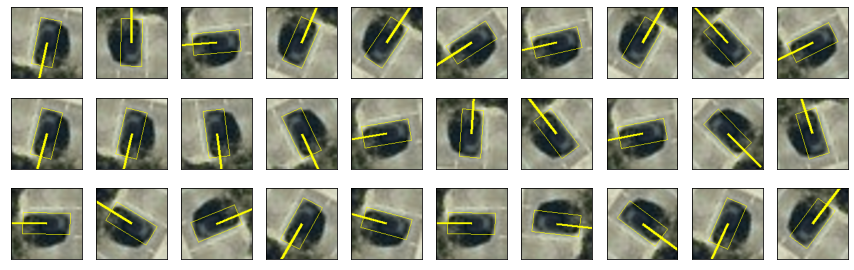

In [32]:
def generate_sample_randomly(f_img, f_mark, with_shift=False, with_scale=False):
    smpl_shift=(0,0)
    SHIFT_C = 2
    if with_shift:
        smpl_shift = (random.randrange(-SHIFT_C, SHIFT_C),
                      random.randrange(-SHIFT_C, SHIFT_C))
    scale = 1
    if with_scale:
        scale = random.uniform(MIN_SCALE, MAX_SCALE)
    smpl_rot = round(random.random() * 360, 5)
    smpl_img, smpl_mark = crop_sample_from_fragment(f_img, f_mark,
                                                   rotation=smpl_rot,
                                                   shift=smpl_shift,
                                                   scale=scale)
    return smpl_img, smpl_mark

def random_sample_generation_check():
    f_img, f_mark = dataset[0]
    plt.figure(figsize=(15,9))
    for_draw = []
    for i in range(30):
        s_img, s_mark = generate_sample_randomly(f_img, f_mark)
        for_draw.append(draw_mark(s_img, s_mark))
    plot_images(for_draw, col_num=10)
random_sample_generation_check()

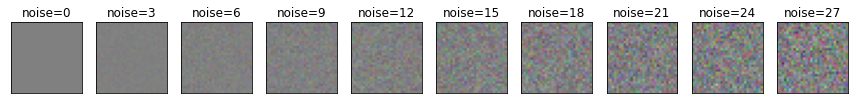

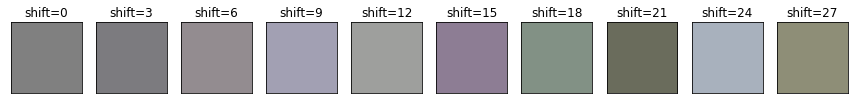

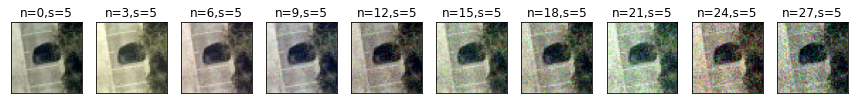

In [34]:
# Noise augmentation

def augment_noise_and_color_shift(x, noise_sigma=None, shift_sigma=None):
    x = x.astype(np.int32)
    if noise_sigma:
        noise = np.random.normal(scale=noise_sigma,size=np.shape(x))
        noise = np.around(noise).astype(np.int32, copy=False)
        x += noise

    if shift_sigma:
        shift = np.ndarray(np.shape(x), dtype=np.int32)
        B_COEFF = 2
        brightness_shift = int(round(random.gauss(0, B_COEFF * shift_sigma)))
        for k in range(3):
            h, w, _ = np.shape(x)
            shift_chanel = np.ndarray((h,w), dtype=np.int32)
            rand = int(round(random.gauss(0, shift_sigma)))
            shift_chanel.fill(rand + brightness_shift)
            shift[:,:,k] = shift_chanel
        x += shift
    return np.clip(x, 0, 255)

def augment_border_check():
    print('Check of border augmentation:\n')
    f_img, f_mark = dataset[0]
    plt.figure(figsize=(2.5, 2.5))
    plot_img(f_img, 'original fragment image')
    plt.show()
    s_img, s_mark = crop_sample_from_fragment(f_img, f_mark,
                                              rotation=135, shift=(2,2))
    x = np.array(s_img, dtype=np.uint8)
    for_draw = []
    for i in range(30):
        for_draw.append(augment_border(x, prob=0.6))
    plot_images(for_draw, col_num=10)
# augment_border_check()

def noise_augmentation_check():
    o_img, _ = dataset[0]
    x = np.array(o_img, dtype=np.uint8)
    IMG_SZ = (30,30)
    grey_x = np.ndarray((IMG_SZ[0],IMG_SZ[1],3),dtype=np.int32)
    grey_x.fill(128)

    COL_NUM = 10
    IMG_W = 1.5

    plt.figure(figsize=(COL_NUM*IMG_W,6))
    for k in range(COL_NUM):
        sigm = 3 * k + 0
        plt.subplot(1,COL_NUM,1+k)
        noisy_x = copy.deepcopy(grey_x)
        noisy_x = augment_noise_and_color_shift(noisy_x, noise_sigma=sigm)
        t = 'noise='+str(sigm)
        plot_img(noisy_x, title=t)
    plt.show()

    plt.figure(figsize=(COL_NUM*IMG_W,6))
    for k in range(COL_NUM):
        sigm = 3 * k + 0
        plt.subplot(1,COL_NUM,1+k)
        shifted_x = copy.deepcopy(grey_x)
        shifted_x = augment_noise_and_color_shift(shifted_x, shift_sigma=sigm)
        t = 'shift='+str(sigm)
        plot_img(shifted_x, title=t)
    plt.show()

    plt.figure(figsize=(COL_NUM*IMG_W,6))
    for k in range(COL_NUM):
        ns = 3 * k + 0
        ss = 5
        plt.subplot(1,COL_NUM,1+k)
        augm_x = copy.deepcopy(x)
        augm_x = augment_noise_and_color_shift(augm_x, noise_sigma=ns,
                                              shift_sigma=ss)
        t = 'n=' + str(ns) + ',s=' + str(ss)
        augm_x = augm_x.astype(np.uint8)
        plot_img(augm_x,title=t)
    plt.show()

noise_augmentation_check()
# as summary recomended noise_sigma = 8, shift_sigma=5

BatchProvider check:
bx shape:  (50, 30, 30, 3)
by shape:  (50, 6)
Some samples as example:


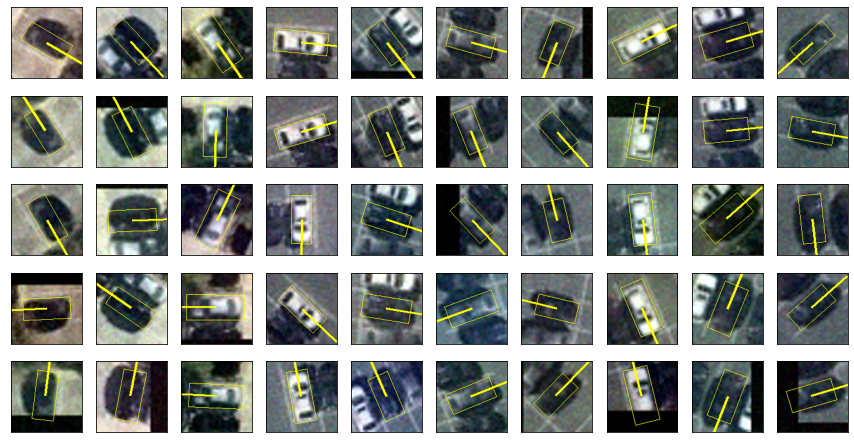

In [35]:
IN_SHAPE = (SIMG_W,SIMG_W,3)
OUT_SHAPE = (6,)

class BatchProvider():
    __ds = None
    __global_counter = 0

    def __init__(self, dataset):
        self.__ds = dataset

    def generate_batch(self, batch_len, border_augm=False, noise_augm=False):
        bx = np.ndarray((batch_len, *IN_SHAPE), dtype=np.uint8)
        by = np.ndarray((batch_len, *OUT_SHAPE), dtype=np.float32)
        for i in range(batch_len):
            idx = self.__global_counter % len(self.__ds)
            f_img, f_mark = self.__ds[idx]
            s_img, s_mark = generate_sample_randomly(f_img, f_mark,
                                                     with_shift=False,
                                                     with_scale=True)
            x, y = convert_sample_to_xy(s_img, s_mark)
            if np.any(np.isnan(y)):
                print('ACHNTUNG! ACHNTUNG! y is nan!')
                raise ValueError
            if border_augm:
                x = augment_border(x)
            if noise_augm:
                x = augment_noise_and_color_shift(x, noise_sigma=9,
                                                  shift_sigma=5)
            bx[i], by[i] = x, y
            self.__global_counter += 1
        return bx, by

def batch_provider_check():
    tiny_ds = dataset[:10]
    b_prov = BatchProvider(tiny_ds)
    bx, by = b_prov.generate_batch(50, border_augm=True, noise_augm=True)
    print('BatchProvider check:')
    print('bx shape: ', np.shape(bx))
    print('by shape: ', np.shape(by))
    print('Some samples as example:')
    for_draw = []
    for k, x in enumerate(bx):
        img = Image.fromarray(x, mode='RGB')
        mark = convert_y_to_mark(by[k], img.size)        
        for_draw.append(draw_mark(img, mark))
    plot_images(for_draw)
batch_provider_check()

# Model

In [21]:
class RotationMetric(tf.keras.metrics.Metric):
    def __init__(self, name='rot_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.diffs = self.add_weight(name='diffs', initializer='zeros', dtype=tf.float32)
        self.num = self.add_weight(name='num', initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        rt, rp = y_true[:,:2], y_pred[:,:2]
        dot = tf.math.reduce_sum(rt * rp, axis=1)
        switch = tf.math.less(dot, 0)
        dot = tf.where(switch, dot * tf.constant(-1.), dot)

        abs_rt = tf.math.sqrt(tf.math.reduce_sum(rt * rt, axis=1))
        abs_rp = tf.math.sqrt(tf.math.reduce_sum(rp * rp, axis=1))
        
        rot = tf.math.acos(tf.clip_by_value(dot / abs_rt / abs_rp, -1, 1))
        rot_deg = rot / tf.constant(math.pi) * 180
        abs_rt_bool = tf.cast(abs_rt, dtype=tf.bool)
        abs_rp_bool = tf.cast(abs_rp, dtype=tf.bool)
        valids = tf.logical_and(tf.cast(abs_rt, dtype=tf.bool),
                                tf.cast(abs_rp, dtype=tf.bool))
        tf_zeros = tf.cast(valids, dtype=tf.float32)  * 0 
        rot_deg = tf.where(valids, rot_deg, tf_zeros)

        num = tf.cast(valids, dtype=tf.float32)
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_to(sample_weight, values.shape)
            rot_deg = tf.multiply(rot_deg, sample_weight)
            num = tf.multiply(num, sample_weight)
        self.diffs.assign_add(tf.reduce_sum(rot_deg)) 
        self.num.assign_add(tf.reduce_sum(num))

    def result(self):
        if self.num > 0.:
            return self.diffs / self.num
        return 0.

In [36]:
class CenterMetric(tf.keras.metrics.Metric):
    def __init__(self, name='center_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.rshifts = self.add_weight(name='rshift', initializer='zeros',
                                    dtype=tf.float32)
        self.nums = self.add_weight(name='nums', initializer='zeros',
                                    dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        rt, rp = y_true[:,2:4], y_pred[:,2:4]
        diff = rp - rt
        rshifts = tf.math.sqrt(tf.math.reduce_sum(diff * diff, axis=1))
        nums = tf.cast(rshifts, dtype=tf.float32)  * 0 + 1
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_to(sample_weight, values.shape)
            rshifts = tf.multiply(rshifts, sample_weight)
            nums = tf.multiply(nums, sample_weight)
        self.rshifts.assign_add(tf.reduce_sum(rshifts)) 
        self.nums.assign_add(tf.reduce_sum(nums))

    def result(self):
        if self.nums > 0.:
            return self.rshifts / self.nums
        return 0.

class WidthMetric(tf.keras.metrics.Metric):
    def __init__(self, name='width_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.rws = self.add_weight(name='rws', initializer='zeros',
                                   dtype=tf.float32)
        self.nums = self.add_weight(name='nums', initializer='zeros',
                                    dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        rws = tf.math.abs(y_pred[:,4] - y_true[:,4])
        nums = tf.cast(rws, dtype=tf.float32)  * 0 + 1
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_to(sample_weight, values.shape)
            rws = tf.multiply(rws, sample_weight)
            nums = tf.multiply(nums, sample_weight)
        self.rws.assign_add(tf.reduce_sum(rws)) 
        self.nums.assign_add(tf.reduce_sum(nums))

    def result(self):
        if self.nums > 0.:
            return self.rws / self.nums
        return 0.

class LengthMetric(tf.keras.metrics.Metric):
    def __init__(self, name='length_metric', **kwargs):
        super().__init__(name=name, **kwargs)
        self.rls = self.add_weight(name='rls', initializer='zeros',
                                   dtype=tf.float32)
        self.nums = self.add_weight(name='nums', initializer='zeros',
                                    dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        rls = tf.math.abs(y_pred[:,5] - y_true[:,5])
        nums = tf.cast(rls, dtype=tf.float32)  * 0 + 1
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            sample_weight = tf.broadcast_to(sample_weight, values.shape)
            rls = tf.multiply(rls, sample_weight)
            nums = tf.multiply(nums, sample_weight)
        self.rls.assign_add(tf.reduce_sum(rls)) 
        self.nums.assign_add(tf.reduce_sum(nums))

    def result(self):
        if self.nums > 0.:
            return self.rls / self.nums
        return 0.

class CustomLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        rt, rp = y_true[:,:2], y_pred[:,:2]
        # tf.print('y_pred', y_pred)
        dot = tf.math.reduce_sum(rt * rp, axis=1)
        abs_rt = tf.math.sqrt(tf.math.reduce_sum(rt * rt, axis=1))
        abs_rp = tf.math.sqrt(tf.math.reduce_sum(rp * rp, axis=1))
        dot = dot / abs_rt / abs_rp
        dot = tf.math.abs(dot)
        dot = tf.clip_by_value(dot, 0.000001, 0.999999)
        valids = tf.logical_and(tf.cast(abs_rt, dtype=tf.bool),
                                tf.cast(abs_rp, dtype=tf.bool))
        tf_zeros = tf.cast(valids, dtype=tf.float32)  * 0
        dot = tf.where(valids, dot, tf_zeros)
        LOSS_C = tf.constant(-2 / math.pi, dtype=tf.float32)
        loss = tf.math.acos(dot) * LOSS_C + 1
        return -loss + abs_rp * 0.0001

def convert_to_y_batch(mark_batch):
    y = np.ndarray((len(mark_batch), *OUT_SHAPE), dtype=np.float32)
    for i, mark in enumerate(mark_batch):
        y[i] = convert_mark_to_y(mark, (30,30))
    return y

def loss_and_metrics_check():
    mark_true_batch = [Mark(25, 25, 10, 20,   0),
                       Mark(25, 25, 10, 20,  0),
                       Mark(25, 25, 10, 20,   0)]

    mark_pred_batch = [Mark(22, 22, 13, 25,   0),
                       Mark(22, 22, 13, 25,  90),
                       Mark(22, 22, 13, 25,  90)]

    y_true_batch = convert_to_y_batch(mark_true_batch)
    y_pred_batch = convert_to_y_batch(mark_pred_batch)

    loss = CustomLoss()
    print('loss:', loss(y_true_batch, y_pred_batch).numpy())

    rot_metric = RotationMetric()
    rot_metric.update_state(y_true_batch,y_pred_batch)
    print('rot_metric result:', rot_metric.result().numpy())

    center_metric = CenterMetric()
    center_metric.update_state(y_true_batch,y_pred_batch)
    print('center_metric result:', center_metric.result().numpy())

    width_metric = WidthMetric()
    width_metric.update_state(y_true_batch,y_pred_batch)
    print('width_metric result:', width_metric.result().numpy())

    length_metric = LengthMetric()
    length_metric.update_state(y_true_batch,y_pred_batch)
    print('length_metric result:', length_metric.result().numpy())

loss_and_metrics_check()

loss: -0.3329316
rot_metric result: 60.0
center_metric result: 1.4142135
width_metric result: 0.75
length_metric result: 0.5555556


In [23]:
def create_model_4():
    model = Sequential([layers.experimental.preprocessing.Rescaling(1./255,
                            input_shape=IN_SHAPE),
                        layers.Conv2D(32, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Conv2D(128, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Conv2D(256, 3, padding='same', activation='relu'),
                        layers.MaxPooling2D(),
                        layers.Dropout(0.3),
                        layers.Flatten(),
                        layers.Dense(1024, activation='relu'),
                        layers.Dense(512, activation='relu'),
                        layers.Dense(256, activation='relu'),
                        layers.Dense(128, activation='relu'),
                        layers.Dense(64, activation='relu'),
                        layers.Dense(6, activation='tanh')])
    model.compile(optimizer='adadelta',
                  loss=CustomLoss(),
                  metrics=[RotationMetric(), CenterMetric(),
                           WidthMetric(), LengthMetric()])
    return model

In [24]:
def find_last_model(models_folder):
    model_list = os.listdir(models_folder)
    model_list = list(map(lambda s: pathlib.Path(s), model_list))
    model_list = list(map(lambda fn: fn.stem, model_list))
    versions = []
    for name in model_list:
        parts = re.split(r'\_+', name)
        if parts[0] == 'model':
            versions.append(int(parts[1]))
    if not versions:
        return ''
    last_version = max(versions)
    last_model = 'model_{}.hdf5'.format(last_version)
    return last_model

def get_incremented_model_version(model_name):
    model_name = str(pathlib.Path(model_name).stem)
    _, version = re.split(r'\_+', model_name)
    return 'model_{}.hdf5'.format(int(version)+1)

def load_model(models_folder):
    last_model = find_last_model(models_folder)
    if last_model:
        last_model = models_folder / last_model
        c_objs = {'CustomLoss': CustomLoss(),
                  'RotationMetric': RotationMetric(),
                  'CenterMetric': CenterMetric(),
                  'WidthMetric': WidthMetric(),
                  'LengthMetric': LengthMetric()}
        print('Model was loaded from file: {}'.format(last_model.name), '\n')
        return tf.keras.models.load_model(str(last_model),
                                           custom_objects=c_objs)
    else:
        return None

def load_or_create_model(models_folder, model_index):
    model = load_model(models_folder)
    if not model:
        if model_index == 1:
            model = create_model_1()
        elif model_index == 2:
            model = create_model_2()
        elif model_index == 3:
            model = create_model_3()
        elif model_index == 4:
            model = create_model_4()
        else:
            assert False
        print('Model was created.\n')
    return model

# Training

In [25]:
train_ds, test_ds = train_test_split(dataset, test_size=0.15, shuffle=False)
b_prov = BatchProvider(train_ds)
print('Length of original dataset: {}'.format(len(dataset)))
print('Length of training dataset: {}'.format(len(train_ds)))
print('Length of test dataset: {}'.format(len(test_ds)))

Length of original dataset: 2951
Length of training dataset: 2508
Length of test dataset: 443


In [26]:
def extract_history_entries(result_list):
    res = {}
    for key in result_list[0].history.keys():
        res[key] = []
    for train_cycle_result in result_list:
        for key in train_cycle_result.history.keys():
            res[key] += train_cycle_result.history[key]
    return res

def train_model(model, batch_size, epochs_num, train_cycles_num):
    training_results = []
    for i in range(1, train_cycles_num + 1):
        print('Cycle #{}. '.format(i), end='')
        t0_bgen = time.time()
        x_batch, y_batch = b_prov.generate_batch(batch_size, border_augm=True,
                                                 noise_augm=True)
        print('Batch generated and splitted ({:.1f} secs).'.format(
            time.time() - t0_bgen))
        t0_cycle = time.time()
        training_res = model.fit(x_batch, y_batch, validation_split=0.20,
                                epochs=epochs_num, verbose=1)
        training_results.append(training_res)
        del x_batch, y_batch
        print('Cycle time: {:.1f}s.'.format(time.time() - t0_cycle))
    gc.collect()
    return training_results

def save_model(model):
    new_model_name = 'model_0.hdf5'
    last_model_name = find_last_model(MODELS_FOLDER)
    if last_model_name:
        new_model_name = get_incremented_model_version(last_model_name)
    model.save(MODELS_FOLDER / new_model_name, save_format='h5')
    print('Model saved in file: ', str(MODELS_FOLDER / new_model_name), '\n\n')
    return new_model_name

def add_entry_in_model_log(models_folder, model, saved_model_name,
                           train_results, evaluation_result, training_time):
    log_path = models_folder / 'training_log.json'
    log = {}
    if log_path.exists():
        with open(log_path) as f:
            log = json.load(f)
    else:
       log['model_description'] = model.to_json()
       log['training_log'] = []
    entry = {}
    entry['saved_model_name'] = saved_model_name
    entry['training_time'] = training_time
    entry['history_entries'] = extract_history_entries(train_results)
    entry['evaluation_result'] = evaluation_result
    log['training_log'].append(entry)
    with open(log_path, mode='w') as f:
        json.dump(log, f, indent=' '*4)

def evaluate_model(model, test_ds):
    test_b_prov = BatchProvider(test_ds)
    test_x, test_y = test_b_prov.generate_batch(10 * len(test_ds),
                                                border_augm=True)
    print('Evaluation:')
    res = model.evaluate(test_x, test_y, return_dict=True)
    del test_x, test_y
    return res

In [39]:
MODELS_FOLDER = pathlib.Path('/content/drive/My Drive/cars_location_3_models/m13')
MODEL_INDEX = 4

BATCH_SIZE = 30000
EPOCHS_NUM = 1
TRAIN_CYCLES_NUM = 1
ITERATIONS_WITH_SAVING_NUM = 0

mem = []

for i in range(ITERATIONS_WITH_SAVING_NUM):
    training_time_0 = time.time()    
    model = load_or_create_model(MODELS_FOLDER, MODEL_INDEX)
    train_results = train_model(model, BATCH_SIZE, EPOCHS_NUM, TRAIN_CYCLES_NUM)
    ev_result = evaluate_model(model, test_ds)
    saved_model_name = save_model(model)
    training_time = time.time() - training_time_0
    add_entry_in_model_log(MODELS_FOLDER, model, saved_model_name,
                           train_results, ev_result, training_time)
    vm = dict(psutil.virtual_memory()._asdict())
    mem.append(vm)
    del model

# Result inspection

Model was loaded from file: model_3.hdf5 

Average rod_diff: 12.3


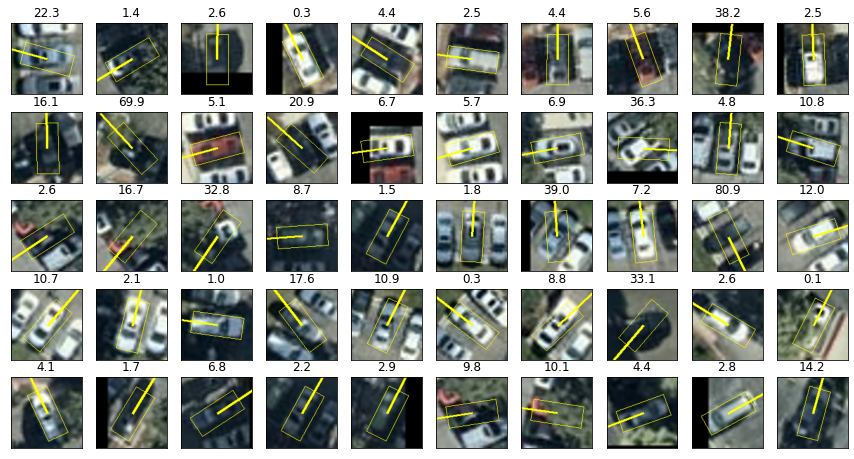

In [40]:
def rotation_diff(y_true, y_pred):
    rt, rp = y_true[:2], y_pred[:2]
    abs_rt = math.sqrt(rt[0] * rt[0] + rt[1] * rt[1])
    abs_rp = math.sqrt(rp[0] * rp[0] + rp[1] * rp[1])
    if abs_rt != 0 and abs_rp != 0:
        dot = rt[0] * rp[0] + rt[1] * rp[1]
        dot = abs(dot)
        try:
            rot = math.acos(dot / abs_rt / abs_rp)
        except ValueError:
            print('dot', dot)
            print('abs_rt', abs_rt)
            print('abs_rp', abs_rp)
            raise ValueError
        rot_deg = rot / math.pi * 180
        return rot_deg
    else:
        return 0.

def inspect_model(models_folder, test_dataset):
    b_prov = BatchProvider(test_dataset)
    x_batch, y_true_batch = b_prov.generate_batch(len(test_dataset),
                                                  border_augm=True)
    model = load_model(models_folder)
    y_pred_batch = model.predict(x_batch)
    images, titles = [], []
    diffs = []
    for k, x in enumerate(x_batch):
        y_true = y_true_batch[k]
        y_pred = y_pred_batch[k]
        img = Image.fromarray(x, mode='RGB')
        rot_dif = rotation_diff(y_true, y_pred)
        diffs.append(rot_dif)
        mark = convert_y_to_mark(y_pred, img.size)        
        images.append(draw_mark(img, mark))
        titles.append('{:.1f}'.format(rot_dif))
    av_diff = ft.reduce(lambda x, y: x + y, diffs) / len(diffs)
    print('Average rod_diff: {:.1f}'.format(av_diff))
    plot_images(images, titles)

inspect_model(MODELS_FOLDER, test_ds[:50])